<a href="https://colab.research.google.com/github/egonloch/DNC/blob/main/Desafio_6_Egon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [332]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

**Target**: Churned

Variáveis do problema

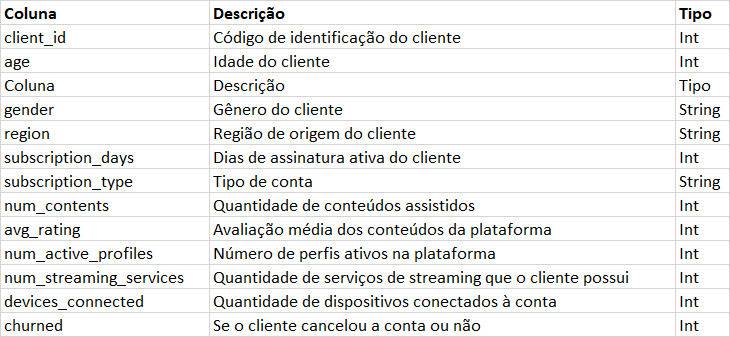

In [333]:
#upload do arquivo
churn = pd.read_csv("/content/streaming_data.csv")
#apresentação dos dados
churn.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,NaN,3,NaN,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,NaN,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,18.0,NaN,1948.0,3.0,Basic,NaN,3,3.88,0.0,14879bcb-1977-4ad8-a7f9-6aa9bf7b872f


# Data Understanding

In [334]:
#descrição dos dados
churn.describe()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Churned
count,66607.000000,56464.000000,52696.000000,9572.000000,77884.000000,60614.000000,61148.000000
mean,43.511072,4385.848505,2.995370,2.496239,3.002273,3.002252,0.243066
std,15.043158,2526.580859,1.414072,1.120700,1.413235,1.154963,0.428938
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,30.000000,2196.000000,2.000000,1.000000,2.000000,1.990000,0.000000
50%,43.000000,4384.000000,3.000000,2.000000,3.000000,3.010000,0.000000
75%,57.000000,6573.000000,4.000000,4.000000,4.000000,4.000000,0.000000
max,69.000000,8759.000000,5.000000,4.000000,5.000000,5.000000,1.000000


In [335]:
#procurar valores nulos nos dados
valores_nulos_totais = churn.isnull().sum()
print("Valores nulos totais no DataFrame:")
print(valores_nulos_totais)

Valores nulos totais no DataFrame:
Age                       11277
Gender                    14516
Time_on_platform          21420
Devices_connected         25188
Subscription_type         25221
Num_streaming_services    68312
Num_active_profiles           0
Avg_rating                17270
Churned                   16736
User_id                       0
dtype: int64


In [336]:
#Substituir valores “NaN” por 0 Colunas → Time_on_platform,
#Num_streaming_services, Churned, Avg_rating, Devices_connected
churn['Time_on_platform'].fillna(0, inplace=True)
churn['Devices_connected'].fillna(0, inplace=True)
churn['Avg_rating'].fillna(0, inplace=True)
churn['Churned'].fillna(0, inplace=True)
churn['Num_streaming_services'].fillna(0, inplace=True)

In [337]:
#Dropar linhas nulas nas colunas Gender, Subscription_type e Age
churn.dropna(subset=['Age', 'Gender', 'Subscription_type'], inplace=True)

In [338]:
#verificando a existencia ainda de valores nulos
valores_nulos_totais = churn.isnull().sum()
print("Valores nulos totais no DataFrame:")
print(valores_nulos_totais)

Valores nulos totais no DataFrame:
Age                       0
Gender                    0
Time_on_platform          0
Devices_connected         0
Subscription_type         0
Num_streaming_services    0
Num_active_profiles       0
Avg_rating                0
Churned                   0
User_id                   0
dtype: int64


In [339]:
#Informações dos dados
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36515 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     36515 non-null  float64
 1   Gender                  36515 non-null  object 
 2   Time_on_platform        36515 non-null  float64
 3   Devices_connected       36515 non-null  float64
 4   Subscription_type       36515 non-null  object 
 5   Num_streaming_services  36515 non-null  float64
 6   Num_active_profiles     36515 non-null  int64  
 7   Avg_rating              36515 non-null  float64
 8   Churned                 36515 non-null  float64
 9   User_id                 36515 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 3.1+ MB


In [340]:
#Transformando valores floats em valores inteiros
churn['Age'] = churn['Age'].astype(int)
churn['Devices_connected'] = churn['Devices_connected'].astype(int)
churn['Num_active_profiles'] = churn['Num_active_profiles'].astype(int)
churn['Avg_rating'] = churn['Avg_rating'].astype(int)
churn['Time_on_platform'] = churn['Time_on_platform'].astype(int)

In [341]:
# Transformando valores churned 0 e 1 por No e Yes
churn['Churned'] = churn['Churned'].map({0: 'Não', 1: 'Sim'})

In [342]:
#Número de usarios churned
churn_agg = churn.groupby("Churned")['User_id'].count().reset_index()
churn_agg = pd.DataFrame(churn_agg)
churn_agg

,Churned,User_id
0,Não,29459
1,Sim,7056


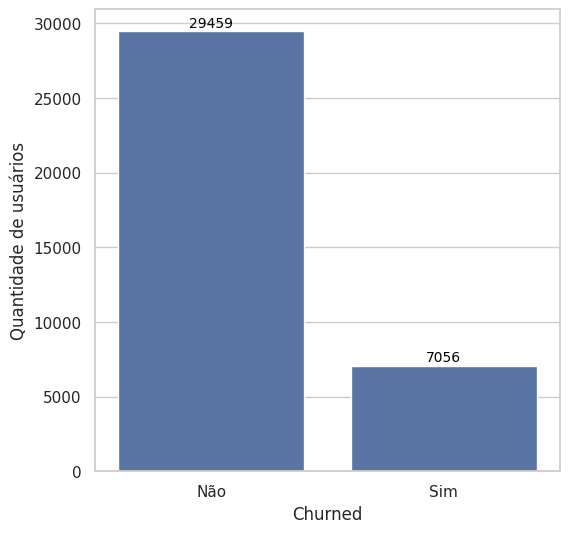

In [343]:
#Grafico de usarios churned
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))

ax = sns.barplot(data=churn_agg, x="Churned", y="User_id")

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 6),
                textcoords='offset points')

plt.xlabel("Churned")
plt.ylabel("Quantidade de usuários")

plt.show()

In [344]:
#Classificação por tipo assinatura
churn_agg = churn.groupby("Subscription_type")['User_id'].count().reset_index()
churn_agg = pd.DataFrame(churn_agg)
churn_agg

,Subscription_type,User_id
0,Basic,12134
1,Premium,12224
2,Standard,12157


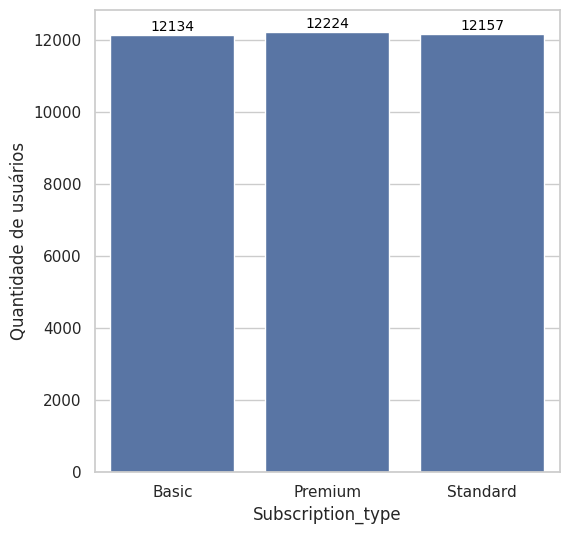

In [345]:
#Grafico por tipo de assinatura
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))

ax = sns.barplot(data=churn_agg, x="Subscription_type", y="User_id")

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 6),
                textcoords='offset points')

plt.xlabel("Subscription_type")
plt.ylabel("Quantidade de usuários")

plt.show()

In [346]:
#Classificaçao por assinatura
churn_agg_gender = churn.groupby("Gender")['User_id'].count().reset_index()
churn_agg_gender = pd.DataFrame(churn_agg_gender)
churn_agg_gender

,Gender,User_id
0,Female,18149
1,Male,18366


# Preparação para modelagens

In [347]:
churn.dtypes

Age                         int64
Gender                     object
Time_on_platform            int64
Devices_connected           int64
Subscription_type          object
Num_streaming_services    float64
Num_active_profiles         int64
Avg_rating                  int64
Churned                    object
User_id                    object
dtype: object

In [348]:
le = LabelEncoder()

le.fit(churn.Churned)
churn.Churned = le.transform(churn.Churned)

In [349]:
X = churn.drop(['User_id', 'Churned'], axis=1)

y = churn[['Churned']]

In [350]:
X = pd.get_dummies(X)

In [351]:
# Instantiate a Min-Max scaling object
mm = MinMaxScaler()
# Fit and transform our feature data into a pandas dataframe
X = pd.DataFrame(mm.fit_transform(X))

In [352]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [353]:
#transformar o array multidimensional resultante do passo anterior em um array unidimensional

y_train = y_train['Churned'].to_numpy().ravel()
y_test = y_test['Churned'].to_numpy().ravel()

# Regressão Logística

In [ ]:
#modelo com classes balanceadas

model = LogisticRegression(class_weight='balanced')
lr = model.fit(X_train, y_train)

In [ ]:
lr.predict(X_test)

In [ ]:
X_test.assign(churn = y_test).assign(label = lr.predict(X_test))

In [ ]:
print('--------------------Previsão-----------------\n')
y_pred = lr.predict(X_test)

#Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Churn', 'Churn']).plot()
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.title('Projetado')

In [ ]:
print(f"Acurácia (Treino): {accuracy_score(y_train, lr.predict(X_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, lr.predict(X_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, lr.predict(X_train))}")
print(f"Precision (Teste): {precision_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, lr.predict(X_train))}")
print(f"Recall (Teste): {recall_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, lr.predict(X_train))}")
print(f"F1-Score (Teste): {f1_score(y_test, lr.predict(X_test))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, lr.predict_proba(X_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])}")

# Random Forest


In [ ]:
rf = RandomForestClassifier(random_state=42)

In [326]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [327]:
rf.predict(X_test)

array([0, 0, 0, ..., 0, 0, 1])

In [328]:
X_test.assign(churn = y_test).assign(label = rf.predict(X_test))

,0,1,2,3,4,5,6,7,8,9,10,churn,label
13383,0.333333,0.701564,1.0,0.00,0.75,0.2,0.0,1.0,1.0,0.0,0.0,0,0
15268,0.921569,0.641055,0.0,0.00,0.25,0.2,0.0,1.0,1.0,0.0,0.0,0,0
4365,0.235294,0.215321,0.4,0.00,1.00,0.0,1.0,0.0,0.0,1.0,0.0,0,0
20824,0.941176,0.000000,0.0,0.00,1.00,0.4,1.0,0.0,0.0,0.0,1.0,0,0
35469,0.901961,0.789245,0.8,0.00,0.25,0.4,0.0,1.0,1.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12616,0.098039,0.315904,0.0,0.25,0.00,0.4,0.0,1.0,0.0,0.0,1.0,1,0
26973,0.215686,0.246489,0.2,0.75,0.25,0.4,1.0,0.0,1.0,0.0,0.0,0,0
25711,0.705882,0.000000,0.0,0.00,0.75,0.4,1.0,0.0,0.0,0.0,1.0,0,0
29017,0.549020,0.000000,1.0,0.00,0.75,0.2,1.0,0.0,0.0,1.0,0.0,0,0


--------------------Previsão-----------------



Text(0.5, 1.0, 'Projetado')

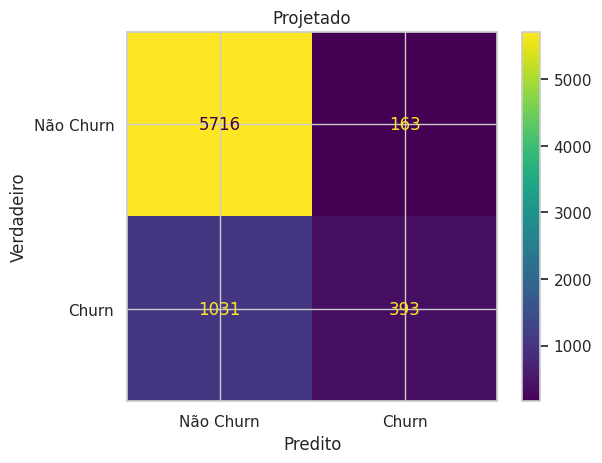

In [329]:
print('--------------------Previsão-----------------\n')
y_pred = rf.predict(X_test)

#Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não Churn', 'Churn']).plot()
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.title('Projetado')

In [330]:
print(f"Acurácia (Treino): {accuracy_score(y_train, rf.predict(X_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, rf.predict(X_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, rf.predict(X_train))}")
print(f"Precision (Teste): {precision_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, rf.predict(X_train))}")
print(f"Recall (Teste): {recall_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, rf.predict(X_train))}")
print(f"F1-Score (Teste): {f1_score(y_test, rf.predict(X_test))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, rf.predict_proba(X_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])}")

Acurácia (Treino): 0.9943858688210324
Acurácia (Teste): 0.8365055456661646
Acurácia Balanceada (Treino): 0.9886838928406199
Acurácia Balanceada (Teste): 0.6241286711796511
Precision (Treino): 0.99137311286844
Precision (Teste): 0.7068345323741008
Recall (Treino): 0.9794034090909091
Recall (Teste): 0.27598314606741575
F1-Score (Treino): 0.9853519113969275
F1-Score (Teste): 0.396969696969697
ROCAUC (Treino): 0.9997371059714512
ROCAUC (Teste): 0.6811963788460546


# Tunning

In [331]:
parameters = {
    'n_estimators': [100, 200, 300],  # Reduzindo o número de árvores
    'max_depth': [None, 10, 20],        # Limitando a profundidade das árvores
    'max_features': ['sqrt', 'log2'],  # Reduzindo o número máximo de features consideradas para dividir um nó
    'min_samples_split': [2, 5, 10],    # Ajustando o número mínimo de amostras necessárias para dividir um nó
    'min_samples_leaf': [1, 2, 4]       # Ajustando o número mínimo de amostras necessárias para ser uma folha
}

grid_search = GridSearchCV(rf, parameters, scoring='accuracy', cv=5, n_jobs=-1)


In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
dict = grid_search.best_estimator_.get_params()

In [ ]:
grid_search.best_estimator_.get_params()

In [ ]:
#mudei para balanced pq os valores não estavam muito precisos

rf_tunned =  RandomForestClassifier(bootstrap = True, ccp_alpha = 0.0,
                                     class_weight = 'balanced', criterion= 'gini',
                                     max_depth = 10, max_features= 'sqrt',
                                     max_leaf_nodes = None,
                                     max_samples = None,
                                     min_impurity_decrease = 0.0,
                                     min_samples_leaf = 1,
                                     min_samples_split = 2,
                                     min_weight_fraction_leaf = 0.0,
                                     n_estimators = 300, n_jobs = None,
                                     oob_score = False, random_state = 42,
                                     verbose = 0, warm_start = False)
rf_tunned

In [ ]:
rf_tunned.fit(X_train, y_train)

In [ ]:
rf_tunned.predict(X_test)

In [ ]:
X_test.assign(churn = y_test).assign(label = rf_tunned.predict(X_test))

In [ ]:
print(f"Acurácia (Treino): {accuracy_score(y_train, rf_tunned.predict(X_train))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, rf_tunned.predict(X_train))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, rf_tunned.predict(X_train))}")
print(f"Precision (Teste): {precision_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, rf_tunned.predict(X_train))}")
print(f"Recall (Teste): {recall_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, rf_tunned.predict(X_train))}")
print(f"F1-Score (Teste): {f1_score(y_test, rf_tunned.predict(X_test))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, rf_tunned.predict_proba(X_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, rf_tunned.predict_proba(X_test)[:,1])}")

**Resultados antes do tuning:**

Recall no conjunto de teste: 0.253 (aproximadamente 25.3%)

F1-Score no conjunto de teste: 0.371 (aproximadamente 37.1%)


**Resultados após o tuning:**

Recall no conjunto de teste: 0.000566 (aproximadamente 0.06%)

F1-Score no conjunto de teste: 0.00113 (aproximadamente 0.11%)


---
\
Essa melhoria sugere que o ajuste de hiperparâmetros foi eficaz em melhorar a capacidade do modelo de identificar instâncias positivas (Churn)